In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pylab as plt
import scipy.sparse as spsparse

from pyscisci.datasource.MAG import MAG
from pyscisci.utils import isin_sorted
from pyscisci.network import cocitation_network #, threshold_network, largest_connected_component_vertices

In [2]:
# set this path to where the MAG database is stored
path2mag = '/home/ajgates/MAG'
path2mag = '/Users/ajgates/Desktop/MAG'
path2mag = '/Volumes/GatesExpansionDrive/DataSets/MAG'

In [3]:
mymag = MAG(path2mag, keep_in_memory=False, show_progress=True) 
# set keep_in_memory=False if you want to load the database each time its needed - good for when you 
# cant keep more than one database in memory at a time
# otherwise keep_in_memory=True will keep each database in memory after its loaded

In [4]:
pub2ref_df = mymag.pub2ref_df


In [5]:
# now lets get the field information

finfo = mymag.fieldinfo_df

# we'll take the fields at level 1
lvl1fields = finfo.loc[finfo['FieldLevel'] == 1][['FieldID', 'FieldName']]
fid2name = {fid:fname for fid, fname in lvl1fields.values}


# load the mapping of the publication to the fields, only for the publications and fields we care about
pub2field_df = mymag.load_pub2field(isindict={'PublicationId':np.sort(pub2ref_df['CitedPublicationId'].unique()), 
                                              'FieldId':np.sort(lvl1fields['FieldID'].unique())})

In [43]:
# we will focus on a seminal paper in the Science of Science:
# NETWORKS OF SCIENTIFIC PAPERS
# Derek De Solla Price
focusid = 2088209891
#focusid = 2023754051

focusid = 2110158660

In [44]:
# we are going to make the co-citation network between all of the publications that cited our focus publication
focus_citing_pubs = np.sort(pub2ref_df.loc[pub2ref_df['CitedPublicationId'] == focusid]['CitingPublicationId'].unique())



In [45]:
cocitenet, cocite2int = cocitation_network(pub2ref_df, focus_pub_ids=focus_citing_pubs, 
                                        focus_constraint='cited', 
                                        temporal=False, show_progress=False)

# cocitenet is our network adjcency matrix
# cocite2int maps the publication ids to the row/col of the adjcency matrix
print("{0} nodes, and {1} edges".format(len(cocite2int), cocitenet.nnz))




353 nodes, and 3702 edges


In [46]:
mat = cocitenet.copy()
mat.setdiag(0)

mat.data[mat.data <=1] = 0
mat.eliminate_zeros()

In [47]:
n_components, labels = spsparse.csgraph.connected_components(mat)
print(n_components)
comidx, compsizes = np.unique(labels, return_counts=True)
print(max(compsizes))

lccidx = np.argmax(compsizes)

lcc = labels==lccidx
lccnodes = np.arange(mat.shape[0])[lcc]
remapnodes = {nid:i for i, nid in enumerate(lccnodes)}
cocite2int = {pid:remapnodes[i] for pid, i in cocite2int.items() if not remapnodes.get(i, None) is None}

lccmat = spsparse.coo_matrix(spsparse.csr_matrix(mat)[lcc][:,lcc])

191
163


In [ ]:
# now lets get the field information

finfo = mymag.fieldinfo_df

# we'll take the fields at level 1
lvl1fields = finfo.loc[finfo['FieldLevel'] == 1][['FieldID', 'FieldName']]
fid2name = {fid:fname for fid, fname in lvl1fields.values}


# load the mapping of the publication to the fields, only for the publications and fields we care about
cocite_pubs = np.sort(list(cocite2int.keys()))
pub2field_df = mymag.load_pub2field(isindict={'PublicationId':cocite_pubs, 
                                              'FieldId':np.sort(lvl1fields['FieldID'].unique())})


In [84]:
cocite_pubs = np.sort(list(cocite2int.keys()))
cocite_fields = pub2field_df.loc[isin_sorted(pub2field_df['PublicationId'].values, cocite_pubs)]

cocite_fields.nunique()

PublicationId    163
FieldId           57
dtype: int64

In [85]:
# most publications are mapped to multiple fields, even at level 1 
# to color our nodes, lets start by seeing which fields appear the most frequently
fieldcount = cocite_fields['FieldId'].value_counts(ascending=False)

for idx in fieldcount.index.values:
    print(idx, fid2name[idx], fieldcount.get(idx))
    
    

124101348 data mining 44
2522767166 data science 26
107826830 environmental resource management 19
162853370 marketing 15
56739046 knowledge management 11
36289849 social science 11
539667460 management science 11
23123220 information retrieval 10
134560507 environmental economics 9
39549134 public relations 8
136764020 world wide web 8
175444787 microeconomics 7
149782125 econometrics 6
105795698 statistics 6
95124753 environmental ethics 5
18903297 ecology 4
55587333 engineering ethics 4
118084267 positive economics 3
50522688 economic growth 3
111472728 epistemology 3
45355965 socioeconomics 3
54750564 commerce 3
148383697 regional science 3
171250308 nanotechnology 3
154945302 artificial intelligence 3
187736073 management 3
40700 industrial organization 3
203014093 immunology 2
161191863 library science 2
112930515 risk analysis 2
548081761 waste management 2
77805123 social psychology 2
175605778 natural resource economics 2
145420912 mathematics education 2
10138342 finance 2
74

In [70]:
reorder_fields = {124101348:0, 2522767166:0, 107826830:1, 162853370:1, 23123220:0}

In [86]:
# we are going to take the largest 5 fields, and group together all of the remaining fields into an "other"
max_fields = 7
reorder_fields = {fid:i for i, fid in enumerate(fieldcount.index.values[:(max_fields+1)])}

cocite_fields['RemappedFields'] = [reorder_fields.get(fid, max_fields) for fid in cocite_fields['FieldId'].values]
cocite_fields.sort_values(by=['RemappedFields'], ascending=True, inplace=True)
cocite_fields.drop_duplicates(subset=['PublicationId'], keep='first', inplace=True)

cocite_fields.reset_index(inplace=True, drop=True)

<ipython-input-86-42c28e24154a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cocite_fields['RemappedFields'] = [reorder_fields.get(fid, max_fields) for fid in cocite_fields['FieldId'].values]
<ipython-input-86-42c28e24154a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cocite_fields.sort_values(by=['RemappedFields'], ascending=True, inplace=True)
<ipython-input-86-42c28e24154a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

In [87]:
fieldcount = cocite_fields['RemappedFields'].value_counts(ascending=False)
reorder_fields2 = {i:idx for idx, i in reorder_fields.items()}
for idx in fieldcount.index.values[:(max_fields+1)]:
    if idx < max_fields:
        print(idx, fid2name[reorder_fields2[idx]], fieldcount.get(idx))
        
print(max_fields, "other", fieldcount.get(max_fields))        

0 data mining 44
2 environmental resource management 18
3 marketing 15
1 data science 15
6 management science 8
5 social science 6
4 knowledge management 4
7 other 53


In [88]:
cocite2field = {cocite2int[pid]:fid for pid, fid in cocite_fields[['PublicationId', 'RemappedFields']].values}
cocite2fieldname = {cocite2int[pid]:fid2name[fid] for pid, fid in cocite_fields[['PublicationId', 'FieldId']].values}

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …


Note: if you're in the IPython notebook, mpld3.show() is not the best command
      to use. Consider using mpld3.display(), or mpld3.enable_notebook().
      See more information at http://mpld3.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8888/    [Ctrl-C to exit]


127.0.0.1 - - [14/Sep/2020 18:41:34] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [14/Sep/2020 18:41:34] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [14/Sep/2020 18:41:34] "GET /mpld3.js HTTP/1.1" 200 -



stopping Server...


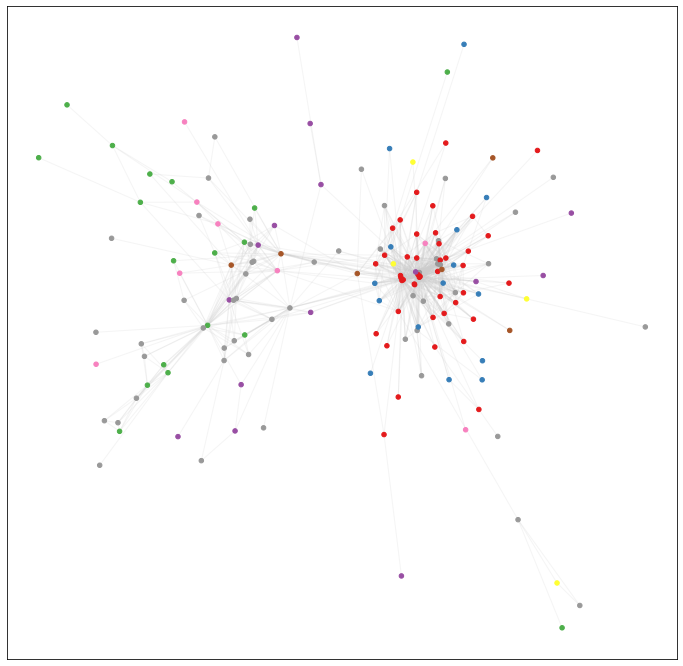

In [89]:
g = nx.from_scipy_sparse_matrix(lccmat, create_using=nx.Graph())

pos = nx.spring_layout(g, k = 0.025, seed=42)

fig, ax = plt.subplots(1,1,figsize=(12,12))         
  
nx.draw_networkx_edges(g, pos, edgelist=g.edges(),
        edge_color = '0.8',
        alpha=0.2,
        ax=ax)

scatter = nx.draw_networkx_nodes(g, pos,
        node_size= 20, 
        node_color=[cocite2field.get(n, 5) for n in range(len(g))] , 
        cmap = 'Set1',
        edgecolors=None, # node outline
        ax = ax)   

labels = [str(cocite2fieldname.get(n, 5)) for n in range(len(g))]
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
mpld3.plugins.connect(fig, tooltip)

mpld3.show()


#plt.show()

In [77]:
import mpld3

In [ ]:
impact_df = []
for y in range(1950, 2021):
    df = pd.read_hdf(os.path.join(path2mag, 'impact', 'impact{}.hdf'.format(y)))[['PublicationId', 'Year', 'Ctotal', 'C10']]
    df['C10norm'] = df['C10'] / df['C10'].mean()
    impact_df.append(df.loc[isin_sorted(df['PublicationId'].values, cocite_pubs)])
    
impact_df = pd.concat(impact_df)



In [ ]:
impact_df.shape

In [ ]:
impact_df['NodeId'] = [cocite2int.get(pid, None) for pid in impact_df['PublicationId'].values]
impact_df.dropna(inplace=True)
impact_df.shape

In [ ]:
impact_df = impact_df.merge(pub2field_df, how='left', on='PublicationId')
impact_df['RemappedFields'].fillna(max_fields, inplace=True)
impact_df.shape

In [ ]:
impact_df.sort_values(by='RemappedFields')

In [ ]:
impact_df['NodeId'] = impact_df['NodeId'].astype(int)
impact_df['RemappedFields'] = impact_df['RemappedFields'].astype(int)


In [ ]:
impact_df.nunique()

In [ ]:
impact_df = impact_df.sort_values('NodeId').reset_index(drop=True)

In [17]:
g = nx.from_scipy_sparse_matrix(lccmat, create_using=nx.Graph())

pos = nx.spring_layout(g, k = 0.025, seed=42)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

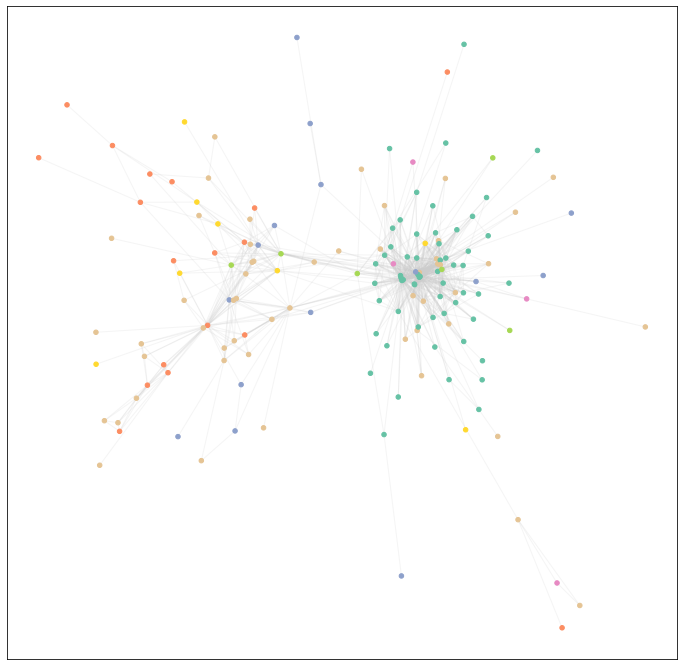

In [101]:
fig, ax = plt.subplots(1,1,figsize=(12,12))         
  
nx.draw_networkx_edges(g, pos, edgelist=g.edges(),
        edge_color = '0.8',
        alpha=0.2,
        ax=ax)

nx.draw_networkx_nodes(g, pos,
        node_size= 20, 
                       cmap='Set2',
        node_color=[cocite2field.get(n, 5) for n in range(len(g))] , 
        edgecolors=None, # node outline
                       vmax = 9,
        ax = ax)   
plt.savefig('DiversityCocitiation.pdf')
plt.show()

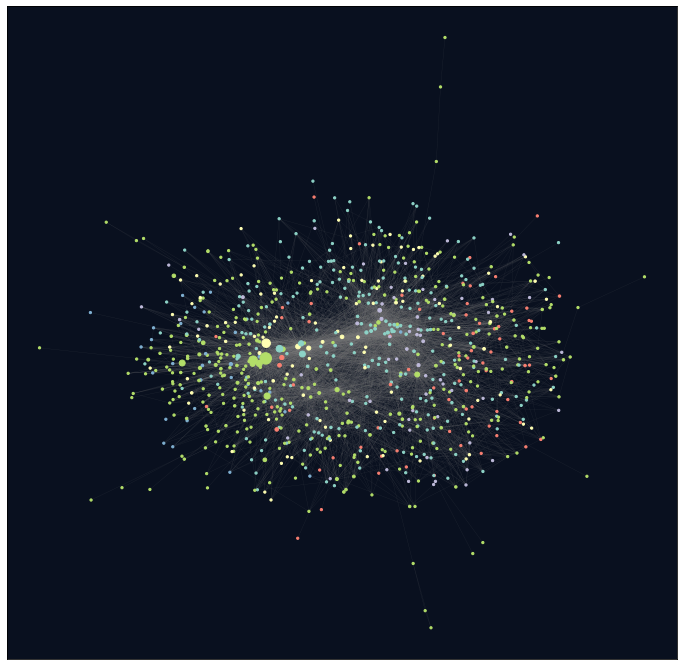

In [213]:
fig, ax = plt.subplots(1,1,figsize=(12,12))         
  
field2color = {0:'#B5CAE3', 1:'#D5ECE4', 2:'#16302B', 3:'#482728', 4:'#B378BA', 5:'#1B73B1'}    
    
nx.draw_networkx_edges(g, pos, edgelist=g.edges(),
        edge_color = '0.5',
        alpha=0.2,
                       width=0.3,
        ax=ax)

nx.draw_networkx_nodes(g, pos,
        #node_size=0.01*impact_df['Ctotal'].values+5, 
        node_color= impact_df['RemappedFields'].values, 
                       cmap='Set3', vmax=10, #[field2color[f] for f in impact_df['RemappedFields'].values], 
        edgecolors=None, # node outline
        ax = ax)

ax.set_facecolor('#09101F')
plt.show()